In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytest
from matplotlib.gridspec import GridSpec
from scipy.stats import randint, uniform
from sklearn.model_selection import ShuffleSplit

import pyMAISE as mai

settings = {
    "verbosity": 0,
    "random_state": 42,
    "test_size": 0.3,
    "num_configs_saved": 5,
    "regression": True,
    "cuda_visible_devices": "-1", # Use CPUs only
}


global_settings = mai.settings.init(settings_changes=settings)

preprocessor = mai.load_xs()

data = preprocessor.min_max_scale()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Num GPUs Available:  0


2023-09-27 22:30:18.304345: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## pyMAISE Initialization

First we initialize pyMAISE with the following 4 parameters:

- `verbosity`: 0 $\rightarrow$ pyMAISE prints no outputs,
- `random_state`: None $\rightarrow$ No random seed is set,
- `test_size`: 0.3 $\rightarrow$ 30% of the data is used for testing,
- `num_configs_saved`: 5 $\rightarrow$ The top 5 hyper-parameter configurations are saved for each model.

With pyMAISE initialized we can load the preprocessor for this data set using `load_fp()`.

In [4]:
structural_hyperparameters = {
    "dense_input": {
        "units": mai.Int(min_value=25, max_value=300, step=10),
        "input_dim": preprocessor.inputs.shape[1],
        "activation": "relu",
        "kernel_initializer": "normal",
    },
    "dense_hidden": {
        "units": mai.Int(min_value=25, max_value=300, step=10),
        "activation": "relu",
        "kernel_initializer": "normal",
        "num_layers": mai.Int(min_value=1, max_value=3),
    },
    "dense_output": {
        "units": preprocessor.outputs.shape[1],
        "input_dim": None,
        "activation": "linear",
        "kernel_initializer": "normal",
    },
}

adam = {
    "learning_rate": 1e-3,
}


model_settings = {
    "models": ["linear", "fnn"],
    "fnn": {
        "structural_params": structural_hyperparameters,
        "optimizer": mai.Choice(["adam"]),
        "adam": adam,
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": 8,
            "epochs": mai.Int(8, 64, 10),
            "validation_split": 0.15,
        },
    },
}

tuning = mai.Tuning(data=data, model_settings=model_settings)
bayesian_search = tuning.nn_bayesian_search(
    models = ["fnn"],
    objective = 'r2_score',
    max_trials = 10,
    cv = 5,
)

Trial 10 Complete [00h 00m 18s]
r2_score: 0.9990987802619806

Best r2_score So Far: 0.9990987802619806
Total elapsed time: 00h 01m 34s


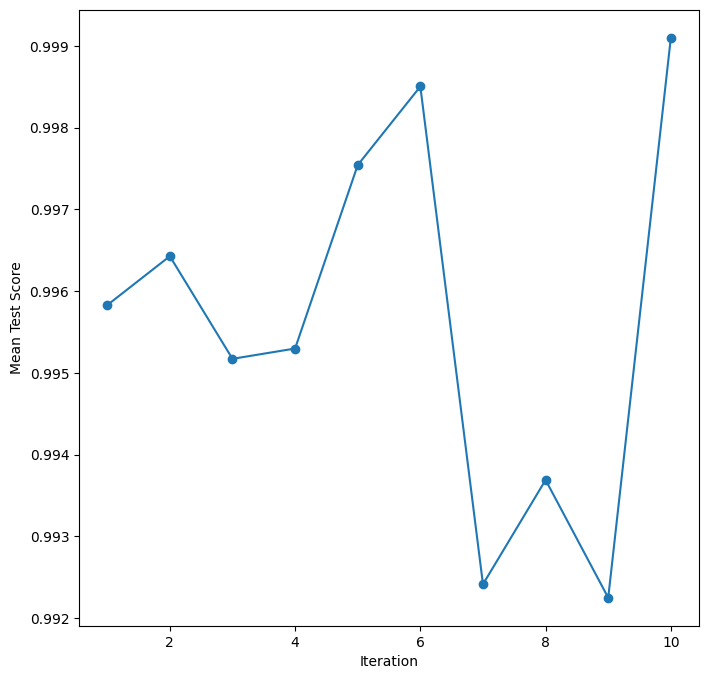

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuning.convergence_plot(model_types="fnn")

In [6]:
new_model_settings = {
    "fnn": {
        "fitting_params":{
            "epochs": 200,
        }
    }
}
postprocessor = mai.PostProcessor(
    data=data,
    models_list=[bayesian_search],
    new_model_settings=new_model_settings,
)

10/10 [==============================] - 0s 664us/step


In [7]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
1,fnn,<keras_tuner.src.engine.hyperparameters.hyperp...,0.999909,0.001333,0.000003,0.001760,0.999165,0.001780,0.000032,0.005626
4,fnn,<keras_tuner.src.engine.hyperparameters.hyperp...,0.999771,0.002493,0.000008,0.002793,0.999024,0.002861,0.000037,0.006081
2,fnn,<keras_tuner.src.engine.hyperparameters.hyperp...,0.999767,0.002209,0.000008,0.002820,0.998491,0.002943,0.000057,0.007563
3,fnn,<keras_tuner.src.engine.hyperparameters.hyperp...,0.997422,0.009097,0.000088,0.009379,0.996856,0.009543,0.000119,0.010914
0,fnn,<keras_tuner.src.engine.hyperparameters.hyperp...,0.996781,0.010201,0.000110,0.010482,0.995959,0.010779,0.000153,0.012375


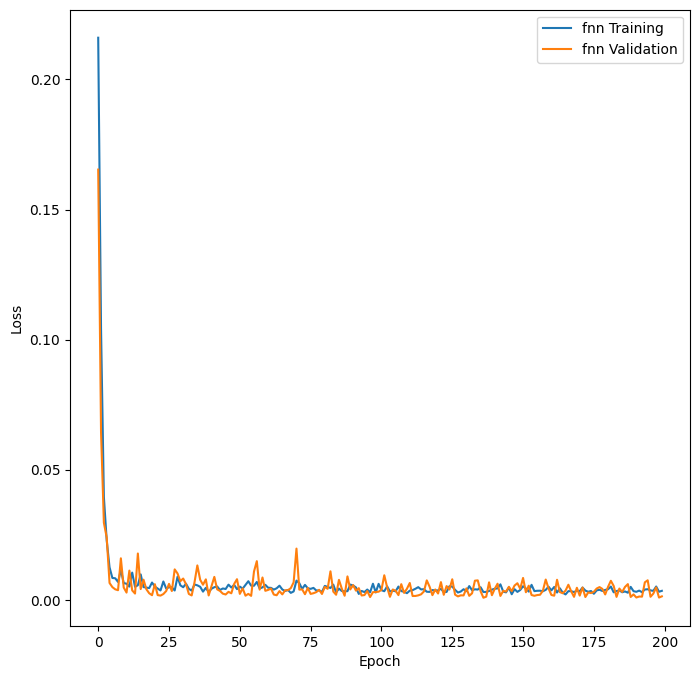

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
ax = postprocessor.nn_learning_plot()